### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# 使用 colab 環境的同學請執行以下程式碼
 %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print("tensorflow版本為: ",tf.__version__)

import os
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
# 此處為google drive中的文件路徑，drive為之前指定的工作跟目錄，要加上位置
# 如果存放的路徑有變，從/content/drive/My Drive/XXXXX...做調整
path = "/content/gdrive/My Drive/深度學習與電腦視覺學習馬拉松-第二屆/Day_44"
os.chdir(path)  #os.chdir():改變當前工作目錄到指定的路徑。
# %cd keras-yolo3
!ls 

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
tensorflow版本為:  1.15.2
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
best_weights_augment.h5			  model.h5	  training.csv
best_weights.h5				  model_plot.png  weights.h5
Day44_train_facial_keypoint_HW.ipynb	  __PDF__.pdf
Day44_train_facial_keypoint_Sample.ipynb  test.csv


In [0]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    #pd.DataFrame.apply（）:用於將給定函數應用於整個DataFrame
    #np.fromstring:將字符轉化成nd.array對象
    #np.values:讀取內部的值
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    #np.vstack:沿著垂直方向將矩陣堆疊起來
    # convert the string image data to float
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    # reshape the matrix
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    # convert to float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    # extract the points 
    points = data[data.columns[:-1]].values

    # 轉換為 float
    #convert it to float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [0]:
# 讀取資料

# training data
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)
# testing data
imgs_test, points_test = load_data(dirname = 'test.csv')
print("圖像資料:", imgs_test.shape, "\n關鍵點資料:", points_test.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)
圖像資料: (1783, 96, 96) 
關鍵點資料: (1783, 1)


In [0]:
# 載入套件
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.


In [0]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    # 建立卷積層，filter=16,即 output space 的深度, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    # 建立池化層，池化大小=2x2，取最大值
    model.add(MaxPooling2D(pool_size=2))
    # 建立卷積層，filter=32,即 output size, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    # 建立池化層，池化大小=2x2，取最大值
    model.add(MaxPooling2D(pool_size=2))
    
    # 建立卷積層，filter=64,即 output size, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    # 建立池化層，池化大小=2x2，取最大值
    model.add(MaxPooling2D(pool_size=2))
    
    # 建立卷積層，filter=128,即 output size, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    # 建立池化層，池化大小=2x2，取最大值
    model.add(MaxPooling2D(pool_size=2))
    
    # Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
    model.add(Flatten())
    # 全連接層: 512個output
    model.add(Dense(512, activation='relu'))
    # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.2
    model.add(Dropout(0.2))
    # 全連接層: 512個output
    model.add(Dense(512, activation='relu'))
    # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.2
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    # 全連接層: 30個output
    model.add(Dense(30))
    return model

In [0]:
model = get_model()
# 配置 loss funtion 和 optimizer
# 在訓練模型之前，您需要配置學習過程
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy']) # 優化器 = adam，損失函數的損失，模型試圖最小化的目標函數它可以是現有損失函數的字符串標識符 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [0]:
# 印出網路結構
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)        

In [0]:
# 載入套件
from keras.callbacks import ModelCheckpoint, History
# model checkpoint
# ModelCheckpoint: 在每個訓練期之後保存模型。
""" 
ModelCheckpoint 參數說明:
verbose :詳細信息模式，0或者1 。
save_weights_only :如果True，那麼只有模型的權重會被保存( model.save_weights(filepath))，否則的話，整個模型會被保存( model.save(filepath))。
"""
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True) #按固定間隔，存儲模型，預設是每個epoch存儲一次模型
# History():把所有事件都記錄到History對象的回調函數。
hist = History()

In [0]:
# training the model(訓練模型)
# model.fit():此函數用以訓練模型
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1),  # 輸入數據
                       points_train, # 標籤
                       validation_split=0.2,  # 用來指定訓練集的20%數據作為驗證集
                       batch_size=64, # 指定進行梯度下降時每個batch包含的樣本數為64
                       callbacks=[checkpoint, hist], # 回調函數
                       shuffle=True,  # 是否在訓練過程中每個epoch前隨機打亂輸入樣本的順序
                       epochs=150, # 訓練終止時的epoch值，訓練將在達到該epoch值時停止
                       verbose=1) # 日誌顯示，0為不在標準輸出流輸出日誌信息，1為輸出進度條記錄，2為每個epoch輸出一行記錄
# save the model weights
# 將參數儲存至 HDF5 檔案（不含模型）
model.save_weights('weights.h5')
# save the model
# model.save:將Keras模型與權重保存在一個model.h5檔案中
model.save('model.h5')


Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 15s 9ms/step - loss: 0.0070 - accuracy: 0.4831 - val_loss: 0.0024 - val_accuracy: 0.4322

Epoch 00001: val_loss improved from inf to 0.00240, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 14s 8ms/step - loss: 0.0019 - accuracy: 0.6624 - val_loss: 0.0020 - val_accuracy: 0.4322

Epoch 00002: val_loss improved from 0.00240 to 0.00197, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 14s 8ms/step - loss: 0.0014 - accuracy: 0.7255 - val_loss: 0.0019 - val_accuracy: 0.4322

Epoch 00003: val_loss improved from 0.00197 to 0.00189, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 14s 8ms/step - loss: 0.0012 - accuracy: 0.7459 - val_loss: 0.0019 - val_accuracy: 0.4322

Epoch 00004: val_loss improved from 0.00189 to 0.00185, saving model to best_weights.h5
Epoch 5/150
1712

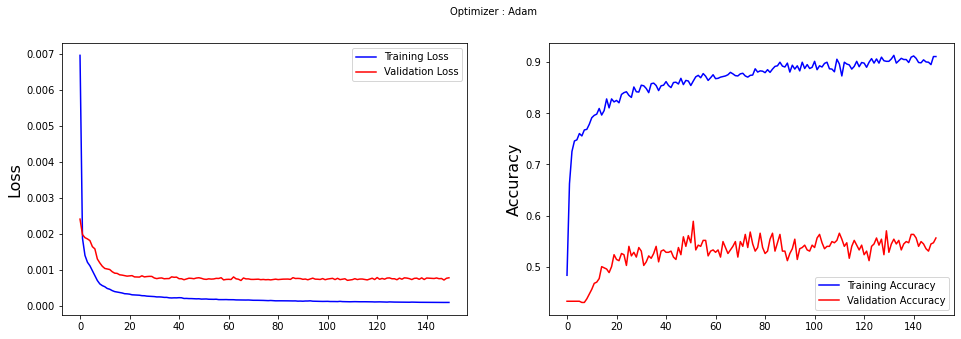

In [0]:
# loss 值的圖
# loss plot ( 繪製訓練 & 驗證的損失值)
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# accuracy plot(繪製訓練 & 驗證的準確率值)
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# 訓練歷史可視化

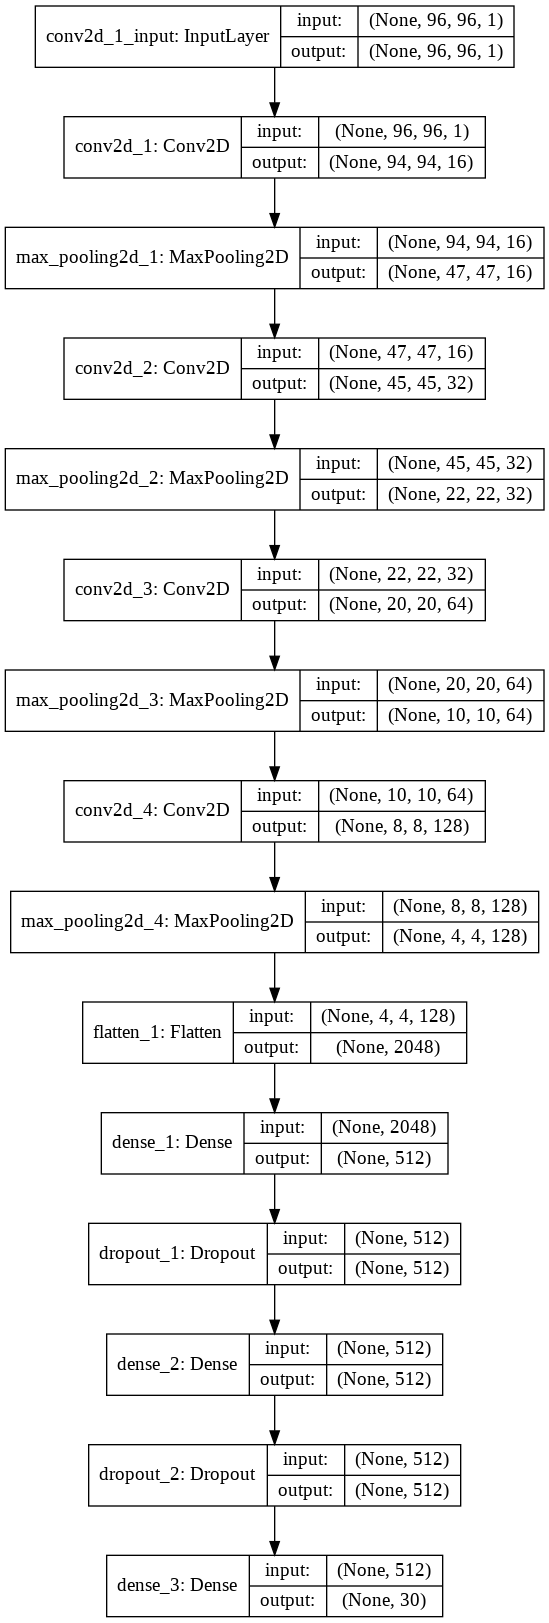

In [0]:
# for saving image of model architecture
from keras.utils.vis_utils import plot_model
import os
#plot_model 模型可視化
plot_model(model, 
           to_file='model_plot.png', 
           show_shapes=True,  # 指定是否顯示輸出數據的形狀
           show_layer_names=True) # 指定是否顯示層名稱

### 觀察 model 在 testing 上的結果

In [0]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [0]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

In [0]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    # np.squeeze:從陣列的形狀中刪除單維度條目
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [0]:
model_with_augment = get_model()
# 編譯: 選擇損失函數、優化方法及成效衡量方式，以compile函數定義損失函數(loss)、優化函數(optimizer)及成效衡量指標(mertrics)。
model_with_augment.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [0]:
# Your code
# Your code here
# 實現圖片以及關機點 label 做左右翻轉的函數
def augment_data(img, points):
    rows, cols = img.shape
    # np.copy(img)複製圖片
    new_img = np.copy(img)
    
    # 翻轉圖片
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = temp
            
    # 翻轉關鍵點 label
    # np.copy(points):複製關鍵點
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
    
    # 調整對稱的 label
    new_points_temp = np.copy(new_points)
    new_points[0:2] = new_points_temp[2:4]
    new_points[2:4] = new_points_temp[0:2]
    new_points[4:6] = new_points_temp[8:10]
    new_points[6:8] = new_points_temp[10:12]
    new_points[8:10] = new_points_temp[4:6]
    new_points[10:12] = new_points_temp[6:8]
    new_points[12:14] = new_points_temp[16:18]
    new_points[14:16] = new_points_temp[18:20]
    new_points[16:18] = new_points_temp[12:14]
    new_points[18:20] = new_points_temp[14:16]
    new_points[22:24] = new_points_temp[24:26]
    new_points[24:26] = new_points_temp[22:24]
        
    return new_img, new_points

In [0]:
flip_img, flip_points = augment_data(imgs_train[0], points_train[0])

# 製作空白的figure來製作圖中圖
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[]) #xticks=[]:x軸刻度、yticks=[]:y軸刻度
plot_keypoints(imgs_train[0], points_train[0]) # 原來的圖片
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[]) #xticks=[]:x軸刻度、yticks=[]:y軸刻度
plot_keypoints(flip_img, flip_points) # 翻轉後的圖片

In [0]:
# 創建 list
aug_imgs_train = []
aug_points_train = []

# 對所有原始資料做 augmentation
for i in range(imgs_train.shape[0]):
    # 做左右翻轉
    aug_img, aug_point = augment_data(imgs_train[i], points_train[i])
    
    # append 原始資料
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
    
    # append 做過 augmentation 後的資料
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

In [0]:
# model checkpoint 
""" 
ModelCheckpoint 參數說明:
verbose :詳細信息模式，0或者1 。
save_weights_only :如果True，那麼只有模型的權重會被保存( model.save_weights(filepath))，否則的話，整個模型會被保存( model.save(filepath))。
"""
checkpoint_aug = ModelCheckpoint('best_weights_augment.h5', verbose=1, save_best_only=True) #按固定間隔，存儲模型，預設是每個epoch存儲一次模型
# training the model
# model.fit():此函數用以訓練模型
# 進行訓練, 訓練過程會存在 hist_model_aug 變數中
hist_model_aug = model_with_augment.fit(aug_imgs_train.reshape(aug_imgs_train.shape[0], 96, 96, 1), # 輸入數據 
                                        aug_points_train,  # 標籤
                                        validation_split=0.2, # 用來指定訓練集的一定比例數據作為驗證集
                                        batch_size=64, # 指定進行梯度下降時每個batch包含的樣本數。
                                        callbacks=[checkpoint_aug, hist],
                                        shuffle=True, #表示是否在訓練過程中每個epoch前隨機打亂輸入樣本的順序
                                        epochs=150, #訓練終止時的epoch值，訓練將在達到該epoch值時停止，
                                        verbose=1) #日誌顯示，0為不在標準輸出流輸出日誌信息，1為輸出進度條記錄，2為每個epoch輸出一行記錄

# Graph Plots

In [0]:
# loss 值的圖
# loss plot ( 繪製訓練 & 驗證的損失值)
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# accuracy plot(繪製訓練 & 驗證的準確率值)
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accurcay'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# 訓練歷史可視化

In [0]:
# for saving image of model architecture
from keras.utils.vis_utils import plot_model
import os
#plot_model 模型可視化
plot_model(model, 
           to_file='model_plot.png', 
           show_shapes=True,  # 指定是否顯示輸出數據的形狀
           show_layer_names=True) # 指定是否顯示層名稱

In [0]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model_with_augment.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

# Reference

https://github.com/susantabiswas/facial-keypoint-regression/blob/master/Facial%20keypoints.ipynb